In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

datafilename = "data_processed-without-outliers.csv"
d = pd.read_csv(datafilename)
print("Loading", len(d), "lines of data (outliers removed).")

resultsfilename = "data_stats-without-outliers.csv"
st = pd.read_csv(resultsfilename)
print("Loading", len(st), "lines of stats.")

Loading 14520 lines of data (outliers removed).
Loading 808 lines of stats.


In [2]:
# comparison by design expertise

types = ["lexical", "recognition"]
fonts = ["arial", "sansforgetica"]
skills = ["Designer", "Non-designer"]
metrics = ["RT", "RT_word", "RT_nonword", "AUC", "AUC_word", "AUC_nonword"]
RTs = metrics[:3]
AUCs = metrics[3:]

cols = pd.MultiIndex.from_product([skills, metrics, ["mean", "SEM"]], names=["skill", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for skill in skills:
        if skill == "Designer":
            r = st[st["isDesigner"] & (st["Font"] == font) & (st["Type"] == t) & (st["StudyID"] == sid)]
        else:
            r = st[(st["isDesigner"] == False) & (st["Font"] == font) & (st["Type"] == t) & (st["StudyID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (skill, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (skill, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-design-expertise.csv")

skill                         Designer                                        \
metric                              RT           RT_word          RT_nonword   
stat                              mean      SEM     mean      SEM       mean   
sid type        font                                                           
1   lexical     arial          2488.91  102.594  1678.88  52.1944     3315.6   
                sansforgetica  2774.13  140.597  1930.02  81.0032    3748.26   
    recognition arial          2454.94  115.525  2297.41   104.78    2612.47   
                sansforgetica   2588.1  120.122  2408.27  107.694    2767.94   
2   lexical     arial          2535.68  146.869  1849.18  96.6757    3226.54   
                sansforgetica  2996.15  155.177  2046.71  96.6929    3984.92   
    recognition arial          2538.25   109.38  2340.88  99.5988    2735.63   
                sansforgetica  2649.75   104.86  2373.57  98.4016     2925.7   

skill                                                                   \
metric                                       AUC              AUC_word   
stat                               SEM      mean         SEM      mean   
sid type        font                                                     
1   lexical     arial          183.735  0.972526  0.00654796       NaN   
                sansforgetica   315.78  0.979423  0.00527942       NaN   
    recognition arial          153.811  0.896521   0.0146142  0.880307   
                sansforgetica  159.232  0.890478   0.0161991  0.870283   
2   lexical     arial          240.248  0.941921   0.0139665       NaN   
                sansforgetica  263.987  0.924924   0.0162821       NaN   
    recognition arial          150.692  0.837129   0.0179227  0.845339   
                sansforgetica  156.337  0.844809   0.0181193  0.861758   

skill                                       ...     Non-designer           \
metric                                      ...          RT_word            
stat                                 SEM    ...             mean      SEM   
sid type        font                        ...                             
1   lexical     arial                NaN    ...          2154.98  130.863   
                sansforgetica        NaN    ...          2378.54  154.536   
    recognition arial           0.018187    ...          2815.68  152.576   
                sansforgetica  0.0213533    ...          2679.59  113.896   
2   lexical     arial                NaN    ...          1934.92  100.845   
                sansforgetica        NaN    ...          2095.47  85.8405   
    recognition arial          0.0221348    ...          2475.98  96.0664   
                sansforgetica  0.0200908    ...          2672.86  108.273   

skill                                                                    \
metric                        RT_nonword                AUC               
stat                                mean      SEM      mean         SEM   
sid type        font                                                      
1   lexical     arial            3344.89  190.415  0.973182  0.00716037   
                sansforgetica    4166.33  278.507     0.975  0.00788058   
    recognition arial            2996.64  270.869  0.901989   0.0154599   
                sansforgetica    3133.56  143.908  0.916016   0.0124777   
2   lexical     arial            3180.58  170.071  0.965326  0.00963764   
                sansforgetica    4041.78  239.742  0.974674  0.00688835   
    recognition arial            2771.12  137.809  0.890965   0.0164647   
                sansforgetica    2967.21  120.796  0.865149    0.017497   

skill                                                                      
metric                         AUC_word            AUC_nonword             
stat                               mean        SEM        mean        SEM  
sid type        font                                                       
1   lexical     aria

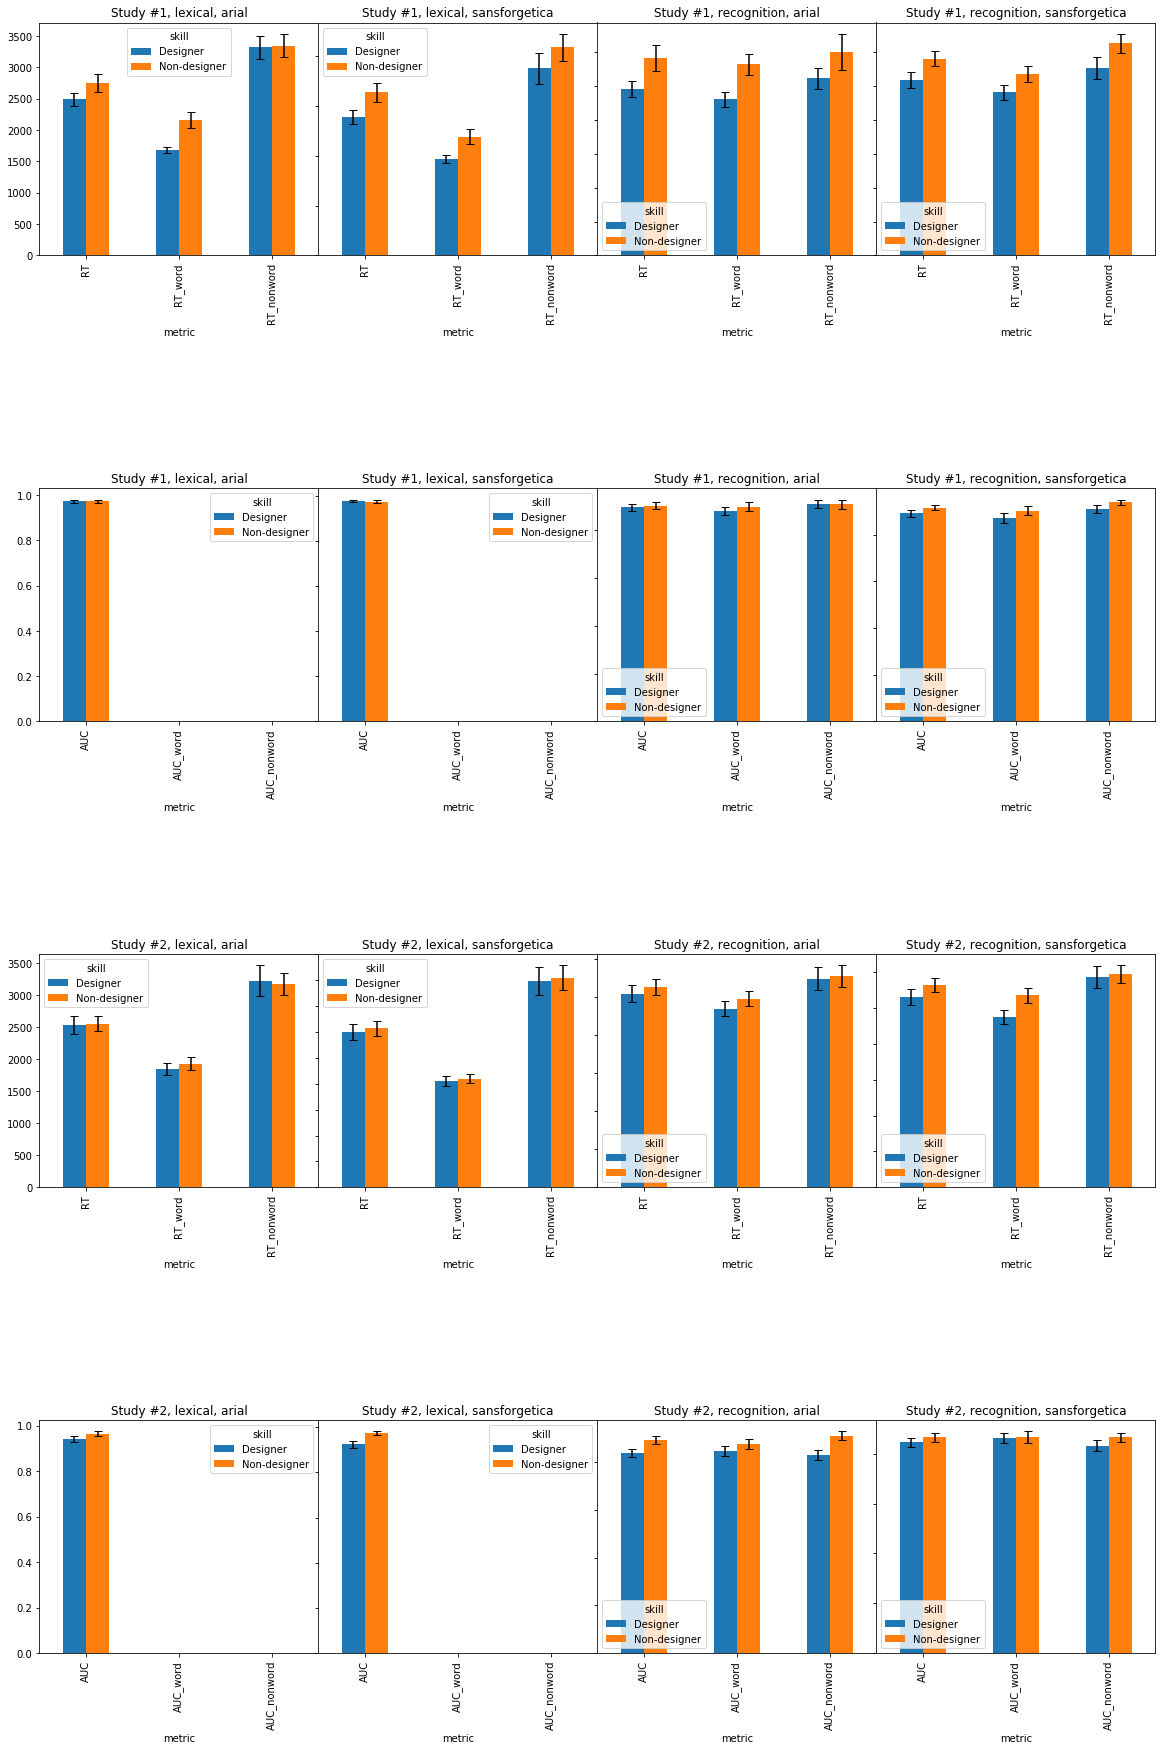

In [3]:
# comparison by design expertise - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
fig.savefig("results/means-by-design-expertise.pdf")

In [5]:
# comparison by order

cols = pd.MultiIndex.from_product([[1, 2], metrics, ["mean", "SEM"]], names=["order", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for order in [1, 2]:
        r = st[(st["Order"] == order) & (st["Font"] == font) & (st["Type"] == t) & (st["StudyID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (order, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (order, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-order.csv")

order                                1                                        \
metric                              RT           RT_word          RT_nonword   
stat                              mean      SEM     mean      SEM       mean   
sid type        font                                                           
1   lexical     arial          2607.31  87.2881  1894.84  69.7922    3328.89   
                sansforgetica  2998.04   117.24  2133.47  85.5192     3937.9   
    recognition arial              NaN      NaN      NaN      NaN        NaN   
                sansforgetica      NaN      NaN      NaN      NaN        NaN   
2   lexical     arial          2611.08  150.699   1953.9  101.332    3268.34   
                sansforgetica  3204.78  139.071  2120.38  93.6438       4296   
    recognition arial          2552.65  121.227  2393.45  108.457    2711.84   
                sansforgetica   2558.9  77.3495  2364.02  97.2278    2753.52   

order                                                                   \
metric                                       AUC              AUC_word   
stat                               SEM      mean         SEM      mean   
sid type        font                                                     
1   lexical     arial          131.758  0.972824  0.00480707       NaN   
                sansforgetica   213.83  0.977417   0.0045736       NaN   
    recognition arial              NaN       NaN         NaN       NaN   
                sansforgetica      NaN       NaN         NaN       NaN   
2   lexical     arial          254.733  0.942658   0.0161518       NaN   
                sansforgetica  210.174   0.95662  0.00893899       NaN   
    recognition arial          168.451  0.843597   0.0176634  0.843137   
                sansforgetica   95.897  0.825666   0.0166221  0.828125   

order                                      ...            2           \
metric                                     ...      RT_word            
stat                                SEM    ...         mean      SEM   
sid type        font                       ...                         
1   lexical     arial               NaN    ...          NaN      NaN   
                sansforgetica       NaN    ...          NaN      NaN   
    recognition arial               NaN    ...       2532.5  93.1272   
                sansforgetica       NaN    ...      2531.34  79.1093   
2   lexical     arial               NaN    ...      1823.32  96.3935   
                sansforgetica       NaN    ...      2012.68  92.6873   
    recognition arial          0.021677    ...      2406.31   90.656   
                sansforgetica  0.020214    ...      2653.63  109.297   

order                                                                    \
metric                        RT_nonword                AUC               
stat                                mean      SEM      mean         SEM   
sid type        font                                                      
1   lexical     arial                NaN      NaN       NaN         NaN   
                sansforgetica        NaN      NaN       NaN         NaN   
    recognition arial            2786.73  149.299  0.899001   0.0105758   
                sansforgetica    2933.78  109.804  0.902062   0.0105348   
2   lexical     arial             3147.9  178.896  0.961163  0.00835337   
                sansforgetica    3706.83  295.062  0.936236   0.0180391   
    recognition arial            2788.32  124.751  0.876881   0.0178377   
                sansforgetica    3145.45  180.998  0.883425   0.0186782   

order                                                                      
metric                         AUC_word            AUC_nonword             
stat                               mean        SEM        mean        SEM  
sid type        font                                                       
1   lexical     arial               NaN        NaN         NaN        NaN  
    

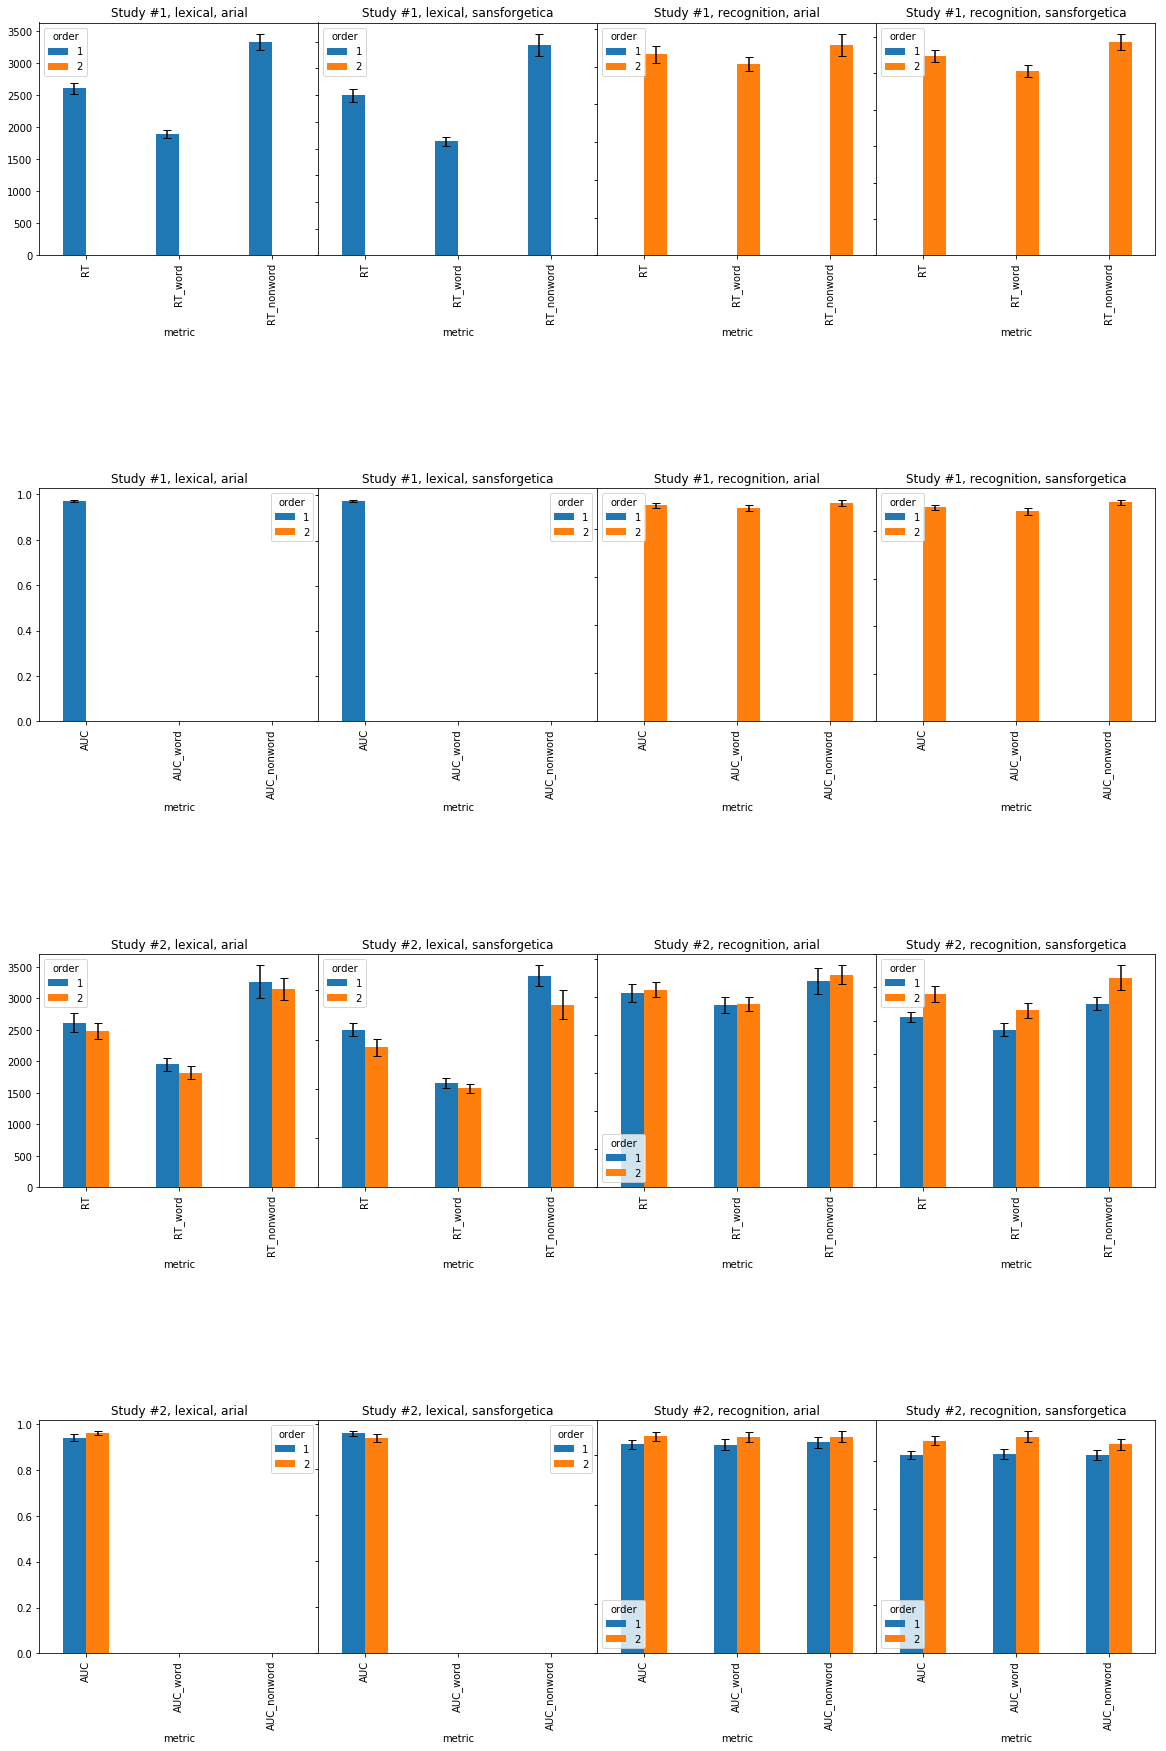

In [6]:
# comparison by order - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
fig.savefig("results/means-by-order.pdf")

In [7]:
# comparison by order (simpler)

cols = pd.MultiIndex.from_product([[1, 2], metrics, ["mean", "SEM"]], names=["order", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types], names=["sid", "type"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t in res.index:
    for order in [1, 2]:
        r = st[(st["Order"] == order) & (st["Type"] == t) & (st["StudyID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t), (order, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t), (order, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-order_simpler.csv")

order                  1                                                 \
metric                RT           RT_word          RT_nonword            
stat                mean      SEM     mean      SEM       mean      SEM   
sid type                                                                  
1   lexical      2802.68  74.2375  2014.16  55.7144    3633.39   127.16   
    recognition      NaN      NaN      NaN      NaN        NaN      NaN   
2   lexical      2916.41  105.919  2039.52  69.0121    3796.85  171.074   
    recognition  2555.86  70.7099  2378.32  72.2945    2733.28   95.082   

order                                                         ...      \
metric                AUC              AUC_word               ...       
stat                 mean         SEM      mean        SEM    ...       
sid type                                                      ...       
1   lexical       0.97512  0.00331311       NaN        NaN    ...       
    recognition       NaN         NaN       NaN        NaN    ...       
2   lexical      0.949839  0.00907363       NaN        NaN    ...       
    recognition  0.834375   0.0120848  0.835417  0.0147431    ...       

order                  2                                                     \
metric           RT_word          RT_nonword                AUC               
stat                mean      SEM       mean      SEM      mean         SEM   
sid type                                                                      
1   lexical          NaN      NaN        NaN      NaN       NaN         NaN   
    recognition  2531.92  60.9377    2860.26  92.5757  0.900532  0.00744519   
2   lexical      1915.29  67.2867    3419.38  171.664  0.949055  0.00978618   
    recognition  2526.44  71.3473    2961.78  109.705   0.88006   0.0128438   

order                                                         
metric           AUC_word             AUC_nonword             
stat                 mean         SEM        mean        SEM  
sid type                                                      
1   lexical           NaN         NaN         NaN        NaN  
    recognition  0.886598  0.00971855    0.916559  0.0084643  
2   lexical           NaN         NaN         NaN        NaN  
    recognition  0.886607   0.0148639    0.872024  0.0148354  

[4 rows x 24 columns]

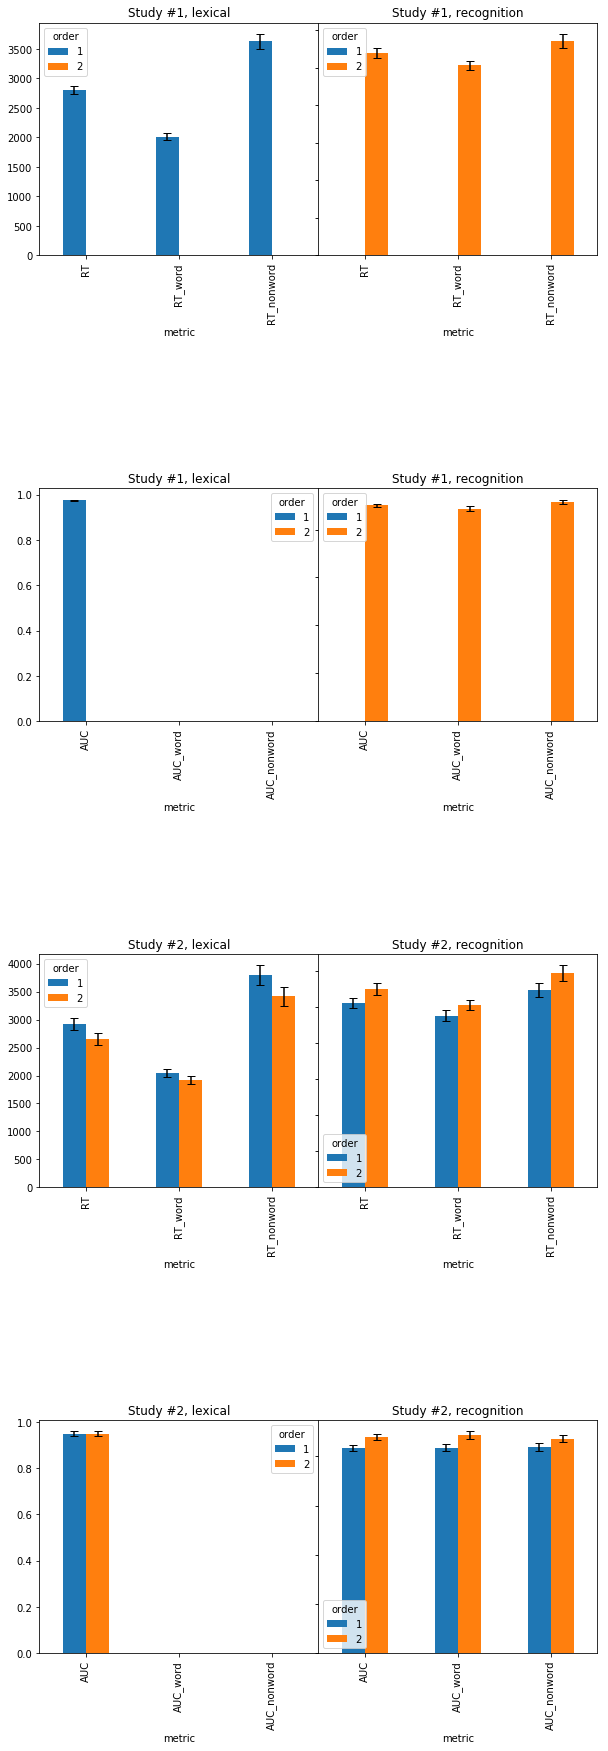

In [8]:
# comparison by order (simpler) - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 2, figsize=(10, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

for sid in [1, 2]:
    for i, t in enumerate(types):
        line = (sid - 1) * 2
        combo = (sid, t)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s" % combo)
fig.savefig("results/means-by-order_simpler.pdf")

In [10]:
# comparison by first font

cols = pd.MultiIndex.from_product([["arial", "sansforgetica"], metrics, ["mean", "SEM"]], names=["first", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for first in ["arial", "sansforgetica"]:
        r = st[(st["Firstfont"] == first) & (st["Font"] == font) & (st["Type"] == t) & (st["StudyID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (first, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (first, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-first-font.csv")

first                            arial                                        \
metric                              RT           RT_word          RT_nonword   
stat                              mean      SEM     mean      SEM       mean   
sid type        font                                                           
1   lexical     arial          2916.82  131.106  2043.49  121.182    3802.14   
                sansforgetica  3114.64  148.003  2241.59  125.849     3989.2   
    recognition arial          2981.43   183.76  2757.26  138.452    3205.61   
                sansforgetica  2707.81  131.852  2568.25   126.82    2847.37   
2   lexical     arial          2611.08  150.699   1953.9  101.332    3268.34   
                sansforgetica  2840.61  163.951  2012.68  92.6873    3706.83   
    recognition arial          2552.65  121.227  2393.45  108.457    2711.84   
                sansforgetica  2899.54  123.785  2653.63  109.297    3145.45   

first                                                                   \
metric                                       AUC              AUC_word   
stat                               SEM      mean         SEM      mean   
sid type        font                                                     
1   lexical     arial          182.562  0.961278  0.00837392       NaN   
                sansforgetica  218.003  0.971189  0.00729137       NaN   
    recognition arial          262.799  0.900937   0.0166208  0.886875   
                sansforgetica  158.469   0.88875   0.0157719   0.87625   
2   lexical     arial          254.733  0.942658   0.0161518       NaN   
                sansforgetica  295.062  0.936236   0.0180391       NaN   
    recognition arial          168.451  0.843597   0.0176634  0.843137   
                sansforgetica  180.998  0.883425   0.0186782  0.901348   

first                                       ...     sansforgetica           \
metric                                      ...           RT_word            
stat                                 SEM    ...              mean      SEM   
sid type        font                        ...                              
1   lexical     arial                NaN    ...           1736.71  57.3056   
                sansforgetica        NaN    ...           2018.46  113.994   
    recognition arial            0.01763    ...            2293.4  114.981   
                sansforgetica  0.0176316    ...           2492.08  93.0824   
2   lexical     arial                NaN    ...           1823.32  96.3935   
                sansforgetica        NaN    ...           2120.38  93.6438   
    recognition arial           0.021677    ...           2406.31   90.656   
                sansforgetica  0.0212286    ...           2364.02  97.2278   

first                                                                    \
metric                        RT_nonword                AUC               
stat                                mean      SEM      mean         SEM   
sid type        font                                                      
1   lexical     arial            2825.43  162.218  0.985106  0.00370167   
                sansforgetica    3883.32  378.094  0.984043  0.00529132   
    recognition arial            2341.12  96.7913  0.896941   0.0129814   
                sansforgetica    3025.71  152.042  0.916223    0.013699   
2   lexical     arial             3147.9  178.896  0.961163  0.00835337   
                sansforgetica       4296  210.174   0.95662  0.00893899   
    recognition arial            2788.32  124.751  0.876881   0.0178377   
                sansforgetica    2753.52   95.897  0.825666   0.0166221   

first                                                                      
metric                         AUC_word            AUC_nonword             
stat                               mean        SEM        mean        SEM  
sid type        font                                                       
1   lexi

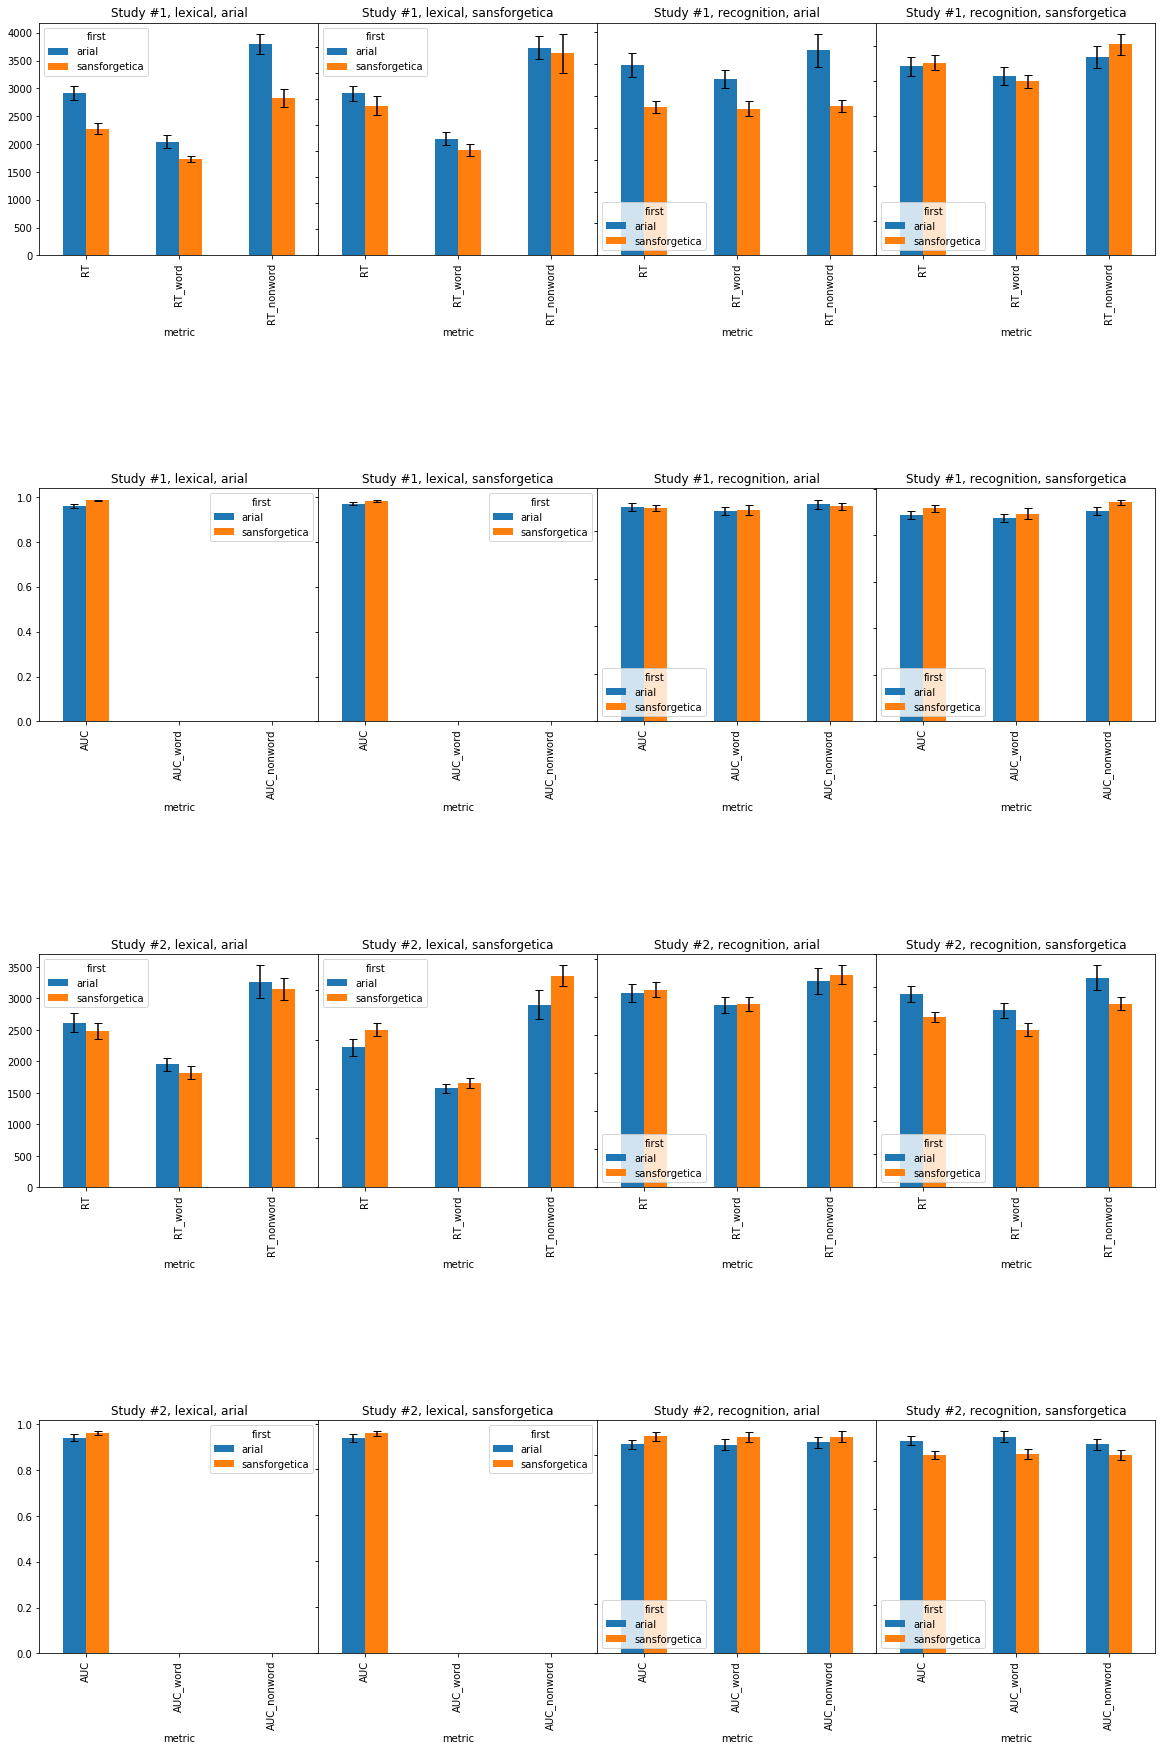

In [11]:
# comparison by first font - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
fig.savefig("results/means-by-first-font.pdf")

# Training



JoM                                                        \
                  count       mean        std   min    25%   50%   75%    max   
Training                                                                        
Graphic designer   68.0  56.735294  21.291592  17.0  50.00  61.0  70.0  100.0   
Letter designer   100.0  55.160000  22.435866  10.0  34.00  59.0  75.0   90.0   
Non-designer      176.0  53.977273  20.943449   1.0  40.75  50.0  71.5   92.0   
Other designer     24.0  49.166667  22.371695  15.0  29.50  50.0  66.0   79.0   
Typographer        20.0  61.000000  17.222996  41.0  42.00  59.5  79.0   82.0   

                    JoL                                                         
                  count       mean        std   min    25%   50%    75%    max  
Training                                                                        
Graphic designer   68.0  66.911765  31.575891   0.0  50.00  75.0  100.0  100.0  
Letter designer   100.0  59.000000  32.473766   0.0  25.00  50.0  100.0  100.0  
Non-designer      176.0  69.886364  30.509739   0.0  50.00  75.0  100.0  100.0  
Other designer     24.0  62.500000  35.355339   0.0  43.75  50.0  100.0  100.0  
Typographer        20.0  65.000000  32.847334  25.0  25.00  62.5  100.0  100.0


# isDesigner



JoM                                                        \
            count       mean        std   min    25%   50%   75%    max   
isDesigner                                                                
False       176.0  53.977273  20.943449   1.0  40.75  50.0  71.5   92.0   
True        212.0  55.537736  21.664908  10.0  37.00  59.0  73.0  100.0   

              JoL                                                       
            count       mean        std  min   25%   50%    75%    max  
isDesigner                                                              
False       176.0  69.886364  30.509739  0.0  50.0  75.0  100.0  100.0  
True        212.0  62.500000  32.518679  0.0  25.0  50.0  100.0  100.0


# Font



JoM                                                      \
               count       mean        std  min   25%   50%   75%    max   
Font                                                                       
arial          194.0  56.711340  20.763139  1.0  47.0  59.0  73.0   92.0   
sansforgetica  194.0  52.948454  21.768148  7.0  35.0  50.0  71.0  100.0   

                 JoL                                                         
               count       mean        std   min   25%    50%    75%    max  
Font                                                                         
arial          194.0  90.463918  17.426121  25.0  75.0  100.0  100.0  100.0  
sansforgetica  194.0  41.237113  22.488119   0.0  25.0   50.0   50.0  100.0


# Firstfont



JoM                                                       \
               count       mean        std   min   25%   50%   75%    max   
Firstfont                                                                   
arial          200.0  55.380000  23.318541   1.0  38.0  59.0  75.0  100.0   
sansforgetica  188.0  54.244681  19.026964  14.0  41.0  50.0  70.0   90.0   

                 JoL                                                       
               count       mean        std  min   25%   50%    75%    max  
Firstfont                                                                  
arial          200.0  62.250000  33.530718  0.0  25.0  50.0  100.0  100.0  
sansforgetica  188.0  69.680851  29.449572  0.0  50.0  75.0  100.0  100.0


# Training



JoM                                                        \
                  count       mean        std   min    25%   50%   75%    max   
Training                                                                        
Graphic designer  100.0  52.240000  19.868822  15.0  38.00  50.0  65.0  100.0   
Letter designer    60.0  58.366667  16.681428  15.0  50.00  58.0  72.0   90.0   
Non-designer      184.0  51.369565  19.481653   6.0  37.75  50.0  68.5   86.0   
Other designer     48.0  53.083333  15.890360  19.0  47.50  50.0  60.0   85.0   
Typographer        28.0  59.000000  29.305542   5.0  50.00  55.5  90.0  100.0   

                    JoL                                                        
                  count       mean        std   min   25%   50%    75%    max  
Training                                                                       
Graphic designer  100.0  70.000000  30.151134  25.0  50.0  75.0  100.0  100.0  
Letter designer    60.0  54.166667  31.274708   0.0  25.0  50.0   75.0  100.0  
Non-designer      184.0  67.391304  33.620172   0.0  50.0  75.0  100.0  100.0  
Other designer     48.0  63.541667  32.599412   0.0  25.0  75.0  100.0  100.0  
Typographer        28.0  73.214286  22.493385  50.0  50.0  75.0  100.0  100.0


# isDesigner



JoM                                                         JoL  \
            count       mean        std  min    25%   50%   75%    max  count   
isDesigner                                                                      
False       184.0  51.369565  19.481653  6.0  37.75  50.0  68.5   86.0  184.0   
True        236.0  54.771186  19.851539  5.0  41.00  50.0  69.0  100.0  236.0   

                                                                 
                 mean        std  min   25%   50%    75%    max  
isDesigner                                                       
False       67.391304  33.620172  0.0  50.0  75.0  100.0  100.0  
True        65.042373  30.794416  0.0  25.0  75.0  100.0  100.0


# Font



JoM                                                       \
               count       mean        std  min   25%   50%    75%    max   
Font                                                                        
arial          210.0  53.280952  19.763001  5.0  40.0  50.0  68.75  100.0   
sansforgetica  210.0  53.280952  19.763001  5.0  40.0  50.0  68.75  100.0   

                 JoL                                                       
               count       mean        std  min   25%   50%    75%    max  
Font                                                                       
arial          210.0  66.071429  32.083468  0.0  50.0  75.0  100.0  100.0  
sansforgetica  210.0  66.071429  32.083468  0.0  50.0  75.0  100.0  100.0


# Firstfont



JoM                                                       \
               count       mean        std  min    25%   50%   75%    max   
Firstfont                                                                   
arial          204.0  52.294118  19.973178  7.0  37.00  50.0  68.0  100.0   
sansforgetica  216.0  54.212963  19.516505  5.0  42.75  50.0  69.0  100.0   

                 JoL                                                       
               count       mean        std  min   25%   50%    75%    max  
Firstfont                                                                  
arial          204.0  61.029412  33.027368  0.0  25.0  50.0  100.0  100.0  
sansforgetica  216.0  70.833333  30.404253  0.0  50.0  75.0  100.0  100.0

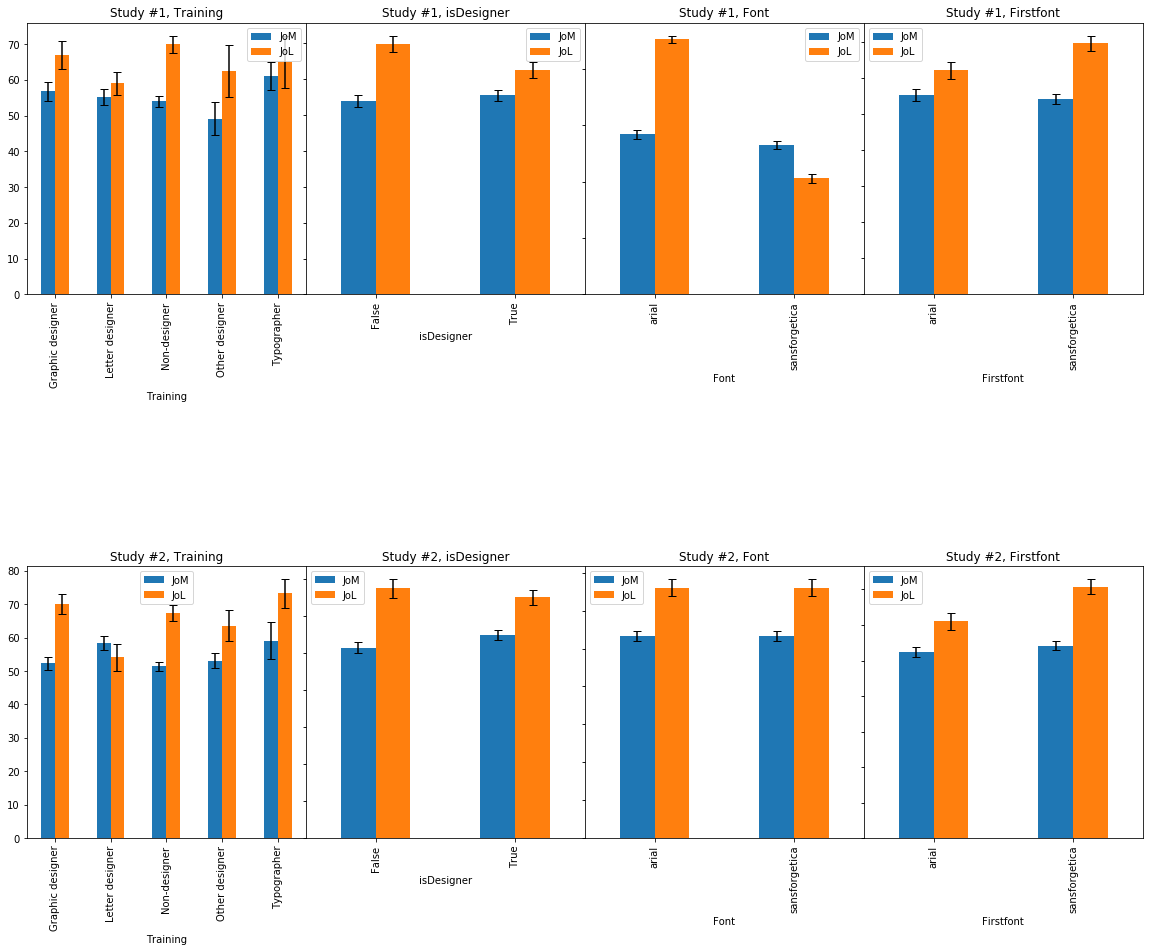

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(20, 15))
plt.subplots_adjust(wspace=0, hspace=1)
for sid in [1, 2]:
    for i, col in enumerate(["Training", "isDesigner", "Font", "Firstfont"]):
        print("#", col)
        print()
        display(st[st["StudyID"] == sid].groupby([col])["JoM", "JoL"].describe())
        print()
        means = st[st["StudyID"] == sid].groupby([col])["JoM", "JoL"].mean()
        errors = st[st["StudyID"] == sid].groupby([col])["JoM", "JoL"].sem()
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[sid-1][i],
                       sharey=True,
                       title="Study #%d, %s" % (sid, col))
fig.savefig("results/JoM-JoL.pdf")

